# CNN

## 1st variation

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:
# Hyper-parameters of the model
num_epochs = 4
batch_size = 4
learning_rate = 0.003

In [81]:
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),   
     transforms.Normalize((0.5), (0.5))])

In [82]:
train_dataset = torchvision.datasets.MNIST(root='path/to/dataset', download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='path/to/dataset', download=True, transform=transform)

In [83]:
type(train_dataset.data)

torch.Tensor

In [84]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [85]:
train_loader

In [86]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 4) #1 channels, 6 filters, 4x4 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16*4*4, 120) #16*4*4= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [87]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Try Adam optimizer instead

In [88]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [2000/15000], Loss: 1.3357
Epoch [1/4], Step [4000/15000], Loss: 0.1473
Epoch [1/4], Step [6000/15000], Loss: 0.0516
Epoch [1/4], Step [8000/15000], Loss: 0.0096
Epoch [1/4], Step [10000/15000], Loss: 0.1108
Epoch [1/4], Step [12000/15000], Loss: 0.0275
Epoch [1/4], Step [14000/15000], Loss: 0.0411
Epoch [2/4], Step [2000/15000], Loss: 0.0146
Epoch [2/4], Step [4000/15000], Loss: 0.4692
Epoch [2/4], Step [6000/15000], Loss: 0.0015
Epoch [2/4], Step [8000/15000], Loss: 0.0018
Epoch [2/4], Step [10000/15000], Loss: 0.5999
Epoch [2/4], Step [12000/15000], Loss: 0.0043
Epoch [2/4], Step [14000/15000], Loss: 0.0060
Epoch [3/4], Step [2000/15000], Loss: 0.1193
Epoch [3/4], Step [4000/15000], Loss: 0.0018
Epoch [3/4], Step [6000/15000], Loss: 0.0040
Epoch [3/4], Step [8000/15000], Loss: 0.0031
Epoch [3/4], Step [10000/15000], Loss: 0.0659
Epoch [3/4], Step [12000/15000], Loss: 0.0049
Epoch [3/4], Step [14000/15000], Loss: 0.0446
Epoch [4/4], Step [2000/15000], Loss: 0.0007
E

In [89]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 98.5 %
Accuracy of zero: 99.07141651190275 %
Accuracy of one: 99.74784930287748 %
Accuracy of two: 98.30480026854649 %
Accuracy of three: 99.11923014190181 %
Accuracy of four: 99.31530297843204 %
Accuracy of five: 98.32134292565948 %
Accuracy of six: 99.42548158161541 %
Accuracy of seven: 98.41979249800478 %
Accuracy of eight: 98.53016578362673 %
Accuracy of nine: 94.57051605311817 %


## 2nd variation

In [90]:
# Hyper-parameters of the model
# increase the number of epochs to see if the model can learn more from the data.
num_epochs = 6  
batch_size = 4
learning_rate = 0.003

In [91]:
# training the network again
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/6], Step [2000/15000], Loss: 0.0003
Epoch [1/6], Step [4000/15000], Loss: 0.0200
Epoch [1/6], Step [6000/15000], Loss: 0.0109
Epoch [1/6], Step [8000/15000], Loss: 0.0012
Epoch [1/6], Step [10000/15000], Loss: 0.0047
Epoch [1/6], Step [12000/15000], Loss: 0.0007
Epoch [1/6], Step [14000/15000], Loss: 0.0003
Epoch [2/6], Step [2000/15000], Loss: 0.0057
Epoch [2/6], Step [4000/15000], Loss: 0.0046
Epoch [2/6], Step [6000/15000], Loss: 0.0001
Epoch [2/6], Step [8000/15000], Loss: 0.0029
Epoch [2/6], Step [10000/15000], Loss: 0.0009
Epoch [2/6], Step [12000/15000], Loss: 0.4316
Epoch [2/6], Step [14000/15000], Loss: 0.1119
Epoch [3/6], Step [2000/15000], Loss: 0.0000
Epoch [3/6], Step [4000/15000], Loss: 0.0000
Epoch [3/6], Step [6000/15000], Loss: 0.0023
Epoch [3/6], Step [8000/15000], Loss: 0.0007
Epoch [3/6], Step [10000/15000], Loss: 0.0019
Epoch [3/6], Step [12000/15000], Loss: 0.0003
Epoch [3/6], Step [14000/15000], Loss: 0.0193
Epoch [4/6], Step [2000/15000], Loss: 0.0050
E

In [92]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 99.25 %
Accuracy of zero: 99.0376498396083 %
Accuracy of one: 99.68851972708396 %
Accuracy of two: 98.10339039946291 %
Accuracy of three: 99.39650954167347 %
Accuracy of four: 98.92160219103047 %
Accuracy of five: 99.31746910164176 %
Accuracy of six: 99.64515038864481 %
Accuracy of seven: 99.05826017557861 %
Accuracy of eight: 99.5727226115194 %
Accuracy of nine: 99.71423768700622 %


# LSTM

## 1st variation

In [93]:
# import libraries
import numpy as np
import pandas as pd

In [94]:
# data 
df = pd.read_csv("https://raw.githubusercontent.com/aaubs/ds-master/main/data/air_passengers.csv")

In [95]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [97]:
X = df.iloc[:, 1:2]
y = df.iloc[:, 1:2] 

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

In [99]:
X_train = X_ss[:50, :]
X_test = X_ss[50:, :]

y_train = y_mm[:50, :]
y_test = y_mm[50:, :] 

In [100]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (50, 1) (50, 1)
Testing Shape (94, 1) (94, 1)


In [101]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [102]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [103]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 1
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

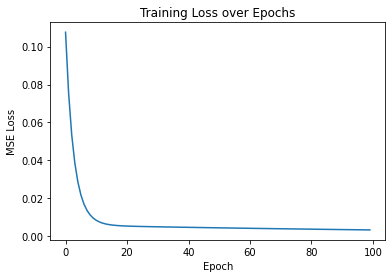

In [104]:
# Initializing Hyperparameters
num_epochs = 100
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [105]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.14804886560854782


In [106]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
     

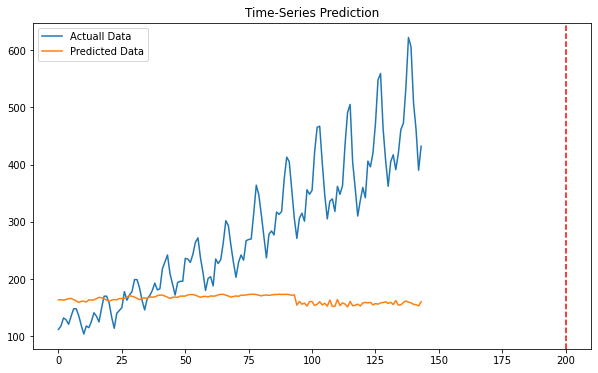

In [107]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y['#Passengers'].values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [108]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>

## 2nd variation

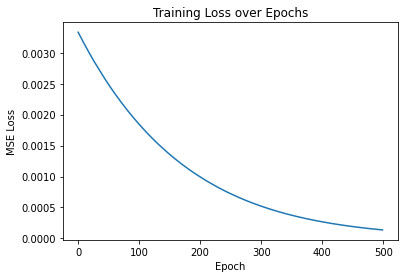

In [109]:
# Initializing Hyperparameters
num_epochs = 500
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [110]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.02595422320533597


In [111]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

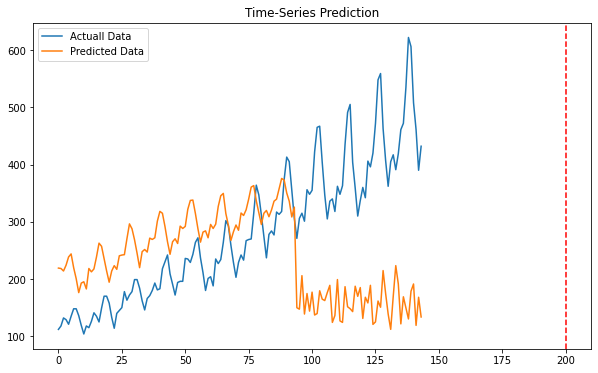

In [112]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y['#Passengers'].values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 